# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

### Признаки
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя
### Целевой признак
* Price — цена (евро)

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
plt.style.use('seaborn-pastel')
import seaborn as sns 
import numpy as np 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

from category_encoders import TargetEncoder

from time import time
from tqdm import tqdm

pd.options.display.max_columns = None

import random

In [2]:
try:
    df = pd.read_csv('E:/BuduBogatym/autos.csv')
except:
    df = pd.read_csv(
        'https://code.s3.yandex.net/datasets/autos.csv')

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Найдём и избавимся от дубликатов, если такие имеются:

In [5]:
print('количество дубликатов:', df.duplicated().sum())

количество дубликатов: 4


In [6]:
df = df.drop_duplicates().reset_index(drop=True)

Удалим столбцы, которые никак не повлияют на модель обучения

In [7]:
df = df.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

In [8]:
num_cols = []

cat_cols = []

for i in range(len(df.columns)):
    if df.dtypes[i] == 'int64':
        num_cols.append(df.columns[i])
    else:
        cat_cols.append(df.columns[i])
        
print(num_cols,'\n', cat_cols)

['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth'] 
 ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']


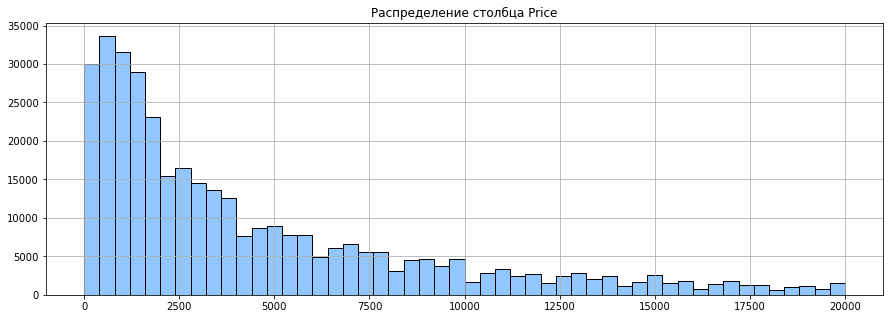

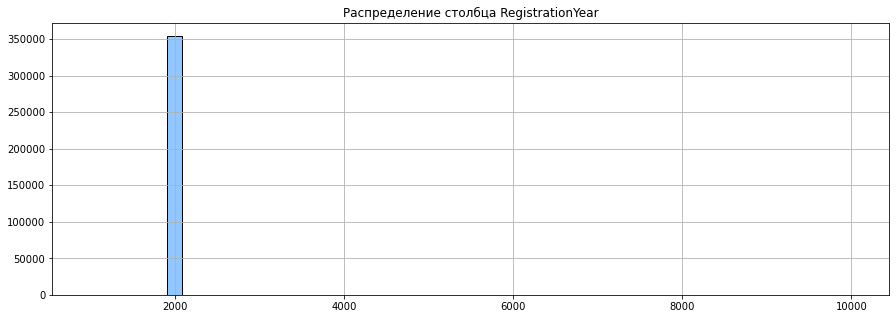

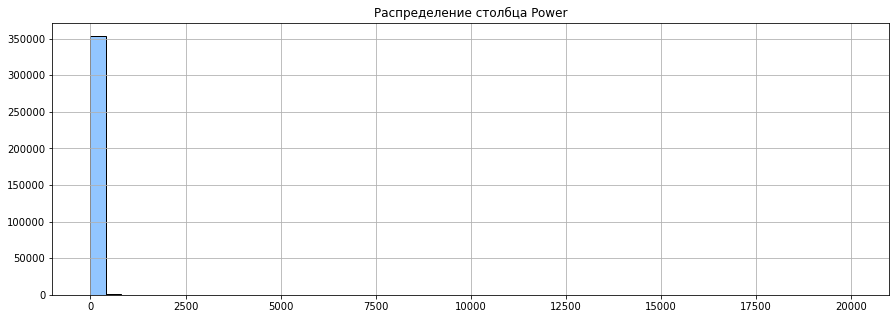

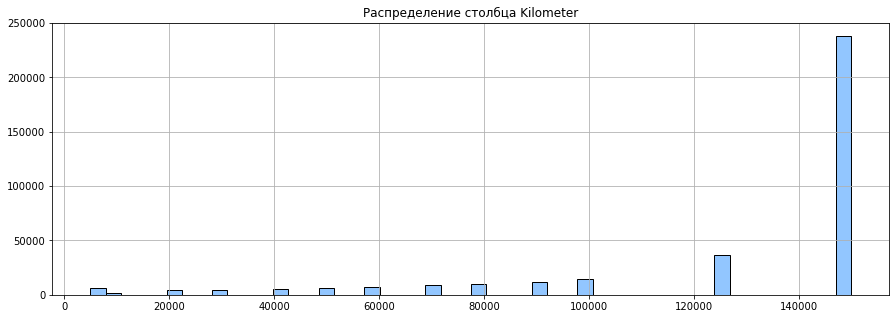

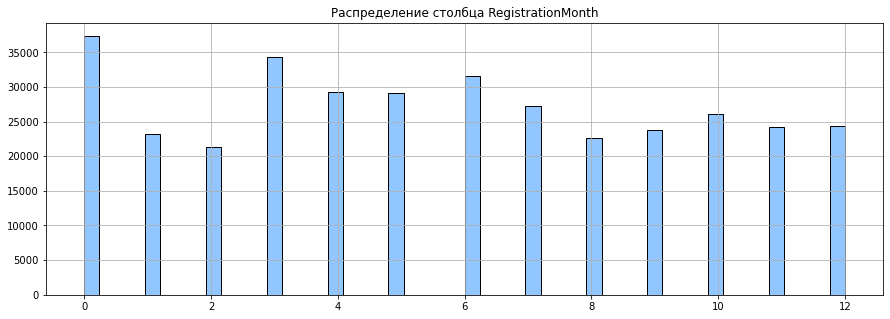

In [9]:
for col in num_cols:
    plt.figure(figsize=(15,5))
    df[col].hist(bins=50, edgecolor='k')
    plt.title(f'Распределение столбца {col}')
    plt.show()

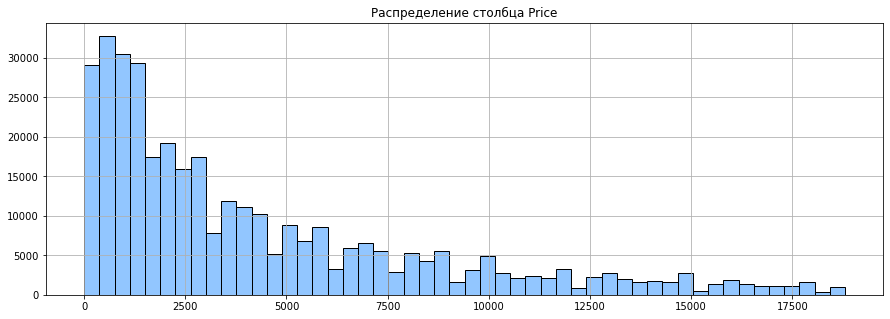

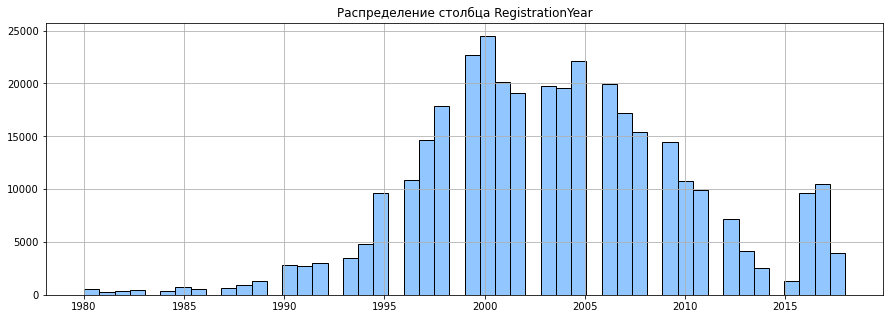

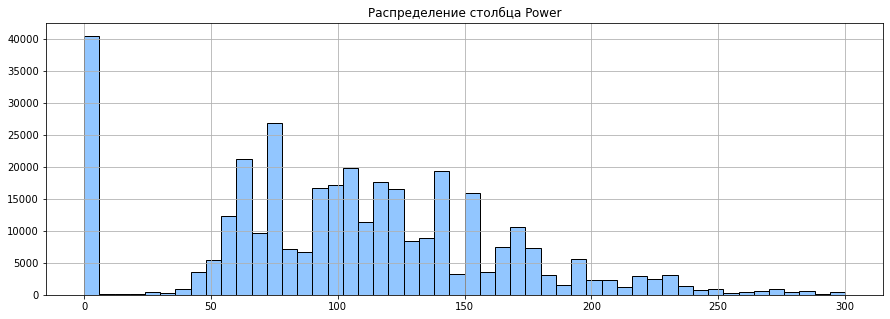

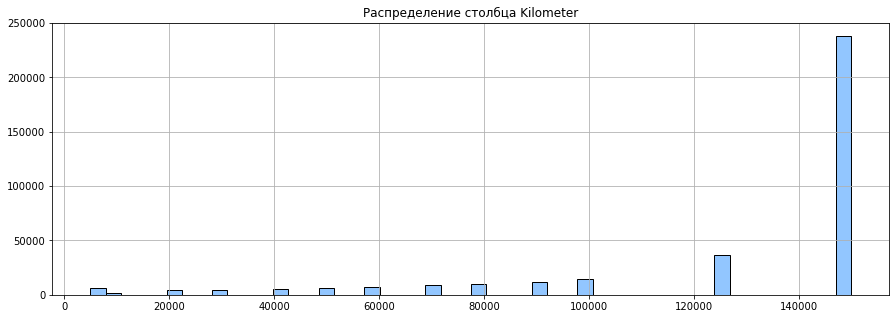

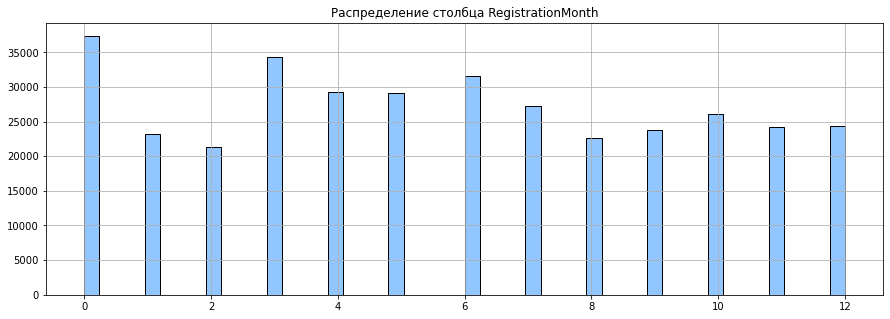

In [10]:

for col in num_cols:
    plt.figure(figsize=(15,5))
    df[col].hist(bins=50, edgecolor='k', range=(df[col].quantile(0.01), df[col].quantile(0.99)))
    plt.title(f'Распределение столбца {col}')
    plt.show()

По резульатам данных гистограмм в месяце регистрации есть нулевые значения, что не может быть

In [11]:
# Заменим нулевые значения на случайные от 1 до 12

df.loc[df['RegistrationMonth'] == 0,'RegistrationMonth'] = random.randint(1,12)

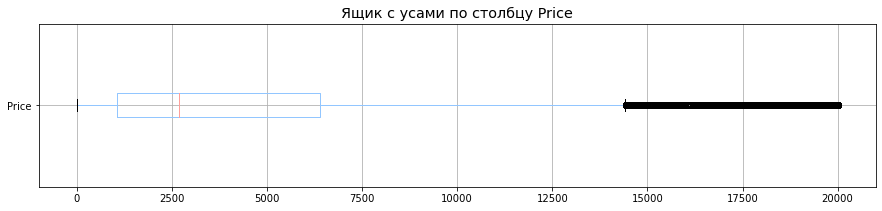

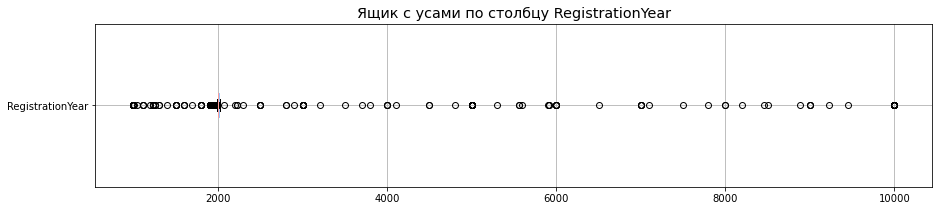

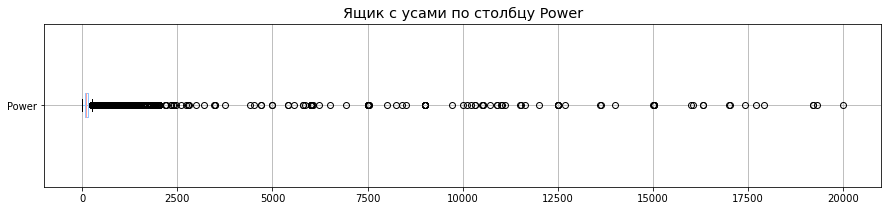

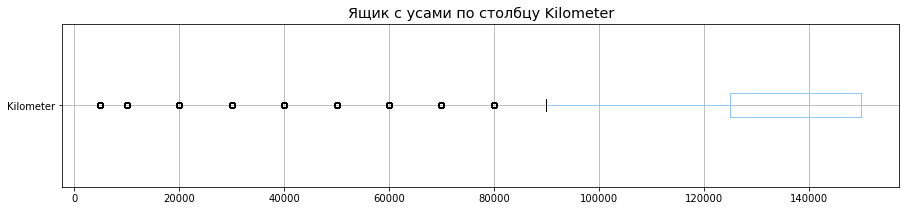

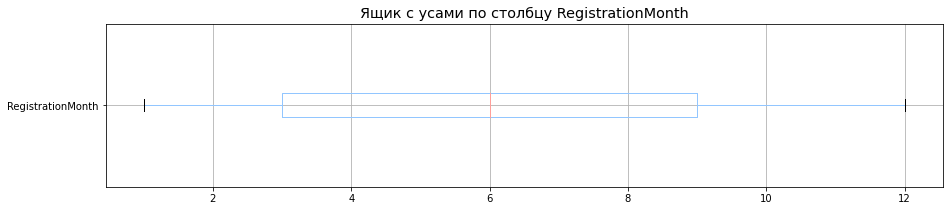

In [12]:
# рассмотрим выбросы по столбцам
for col in num_cols:
    plt.figure(figsize=(15,3))
    df.boxplot(col, vert=False)
    plt.title(f'Ящик с усами по столбцу {col}', fontsize='x-large')
    plt.show()

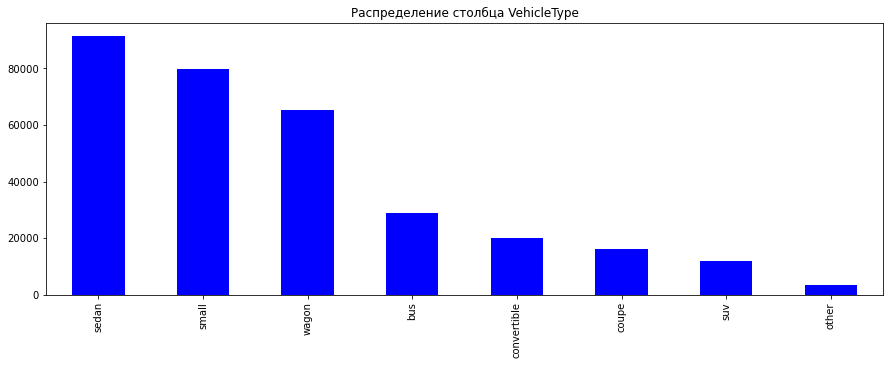

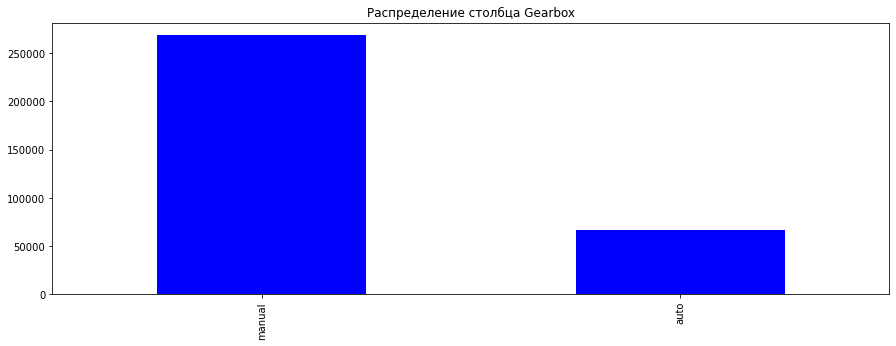

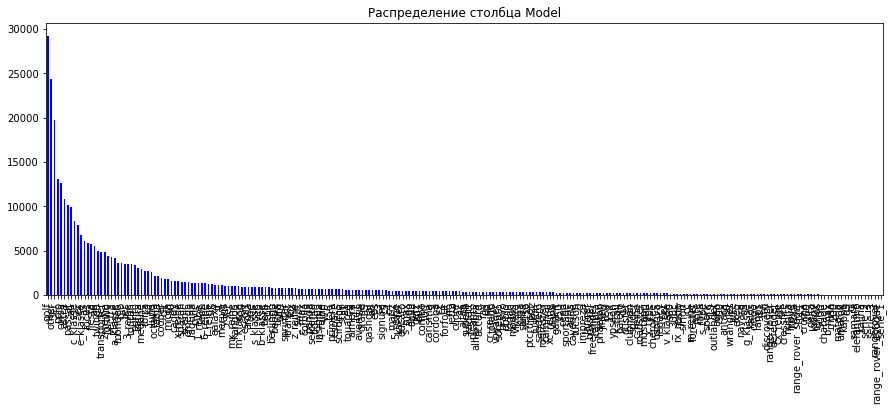

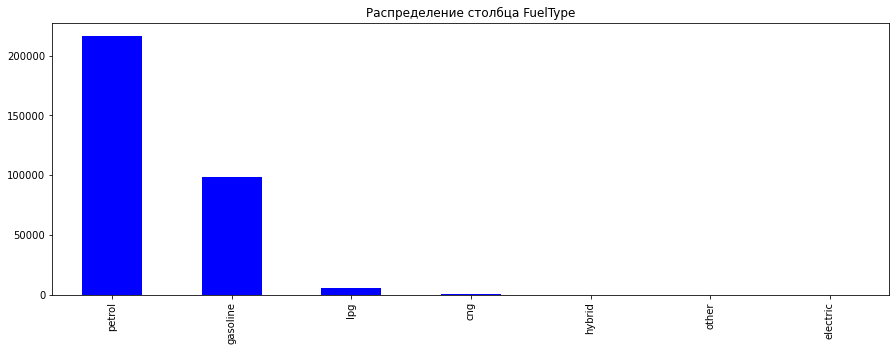

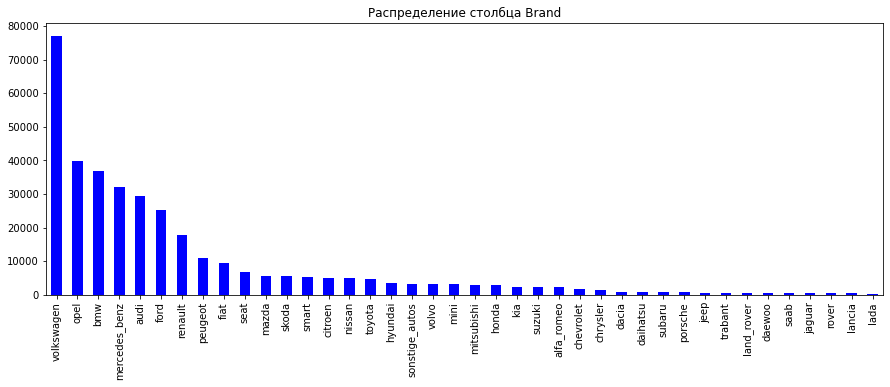

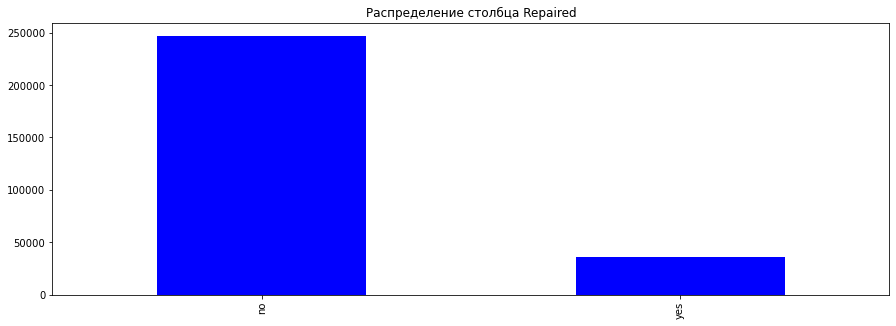

In [13]:
# рассмотрим категориальные признаки
for column in cat_cols:
    plt.figure(figsize=(15,5))
    df[column].value_counts().plot.bar(color='blue', rot=90)
    plt.title(f'Распределение столбца {column}')
    plt.show()

Проверим наличие пропусков в столбцах

In [14]:
df.isnull().sum()

Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
dtype: int64

Пропуски находятся только в столбцах с категориальным данными, поэтмоу заменим их на `unknown`

In [15]:
df = df.fillna('unknown')

### Вывод

* В некоторых столбцах присутствуют выбросы.
* Есть пропуски значений в категориальных столбцах. В численных нет. Проведена замена их на значение unknown
* Столбец с количеством фотографии - не содержит ничего. Все значения 0
* Нулевые значения месяцев заменены на случайное значение

Проверим выбросы в столбцах

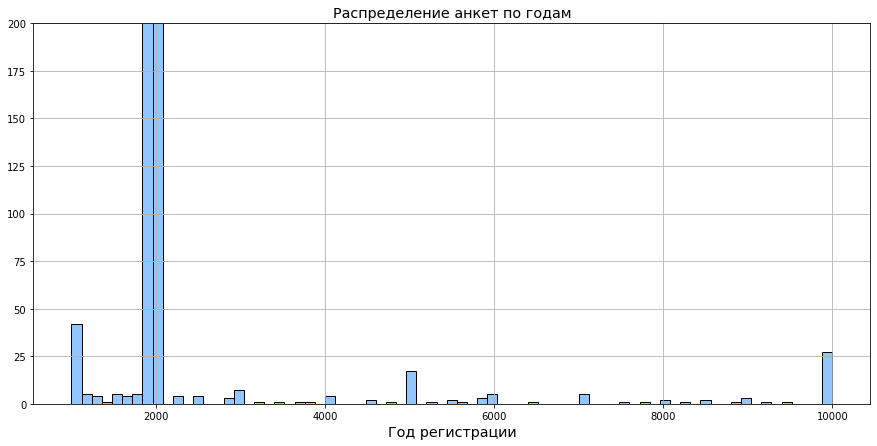

In [16]:
plt.figure(figsize=(15,7))
plt.ylim(0,200)
df['RegistrationYear'].hist(bins=75, edgecolor='k')
plt.title('Распределение анкет по годам', fontsize='x-large')
plt.xlabel('Год регистрации', fontsize='x-large')
plt.show()

Присутствуют нереальные значение лет, избавимся от них

In [17]:
print('Минимальный год:',df['RegistrationYear'].min())
print('Максимальынй год:',df['RegistrationYear'].max())

Минимальный год: 1000
Максимальынй год: 9999


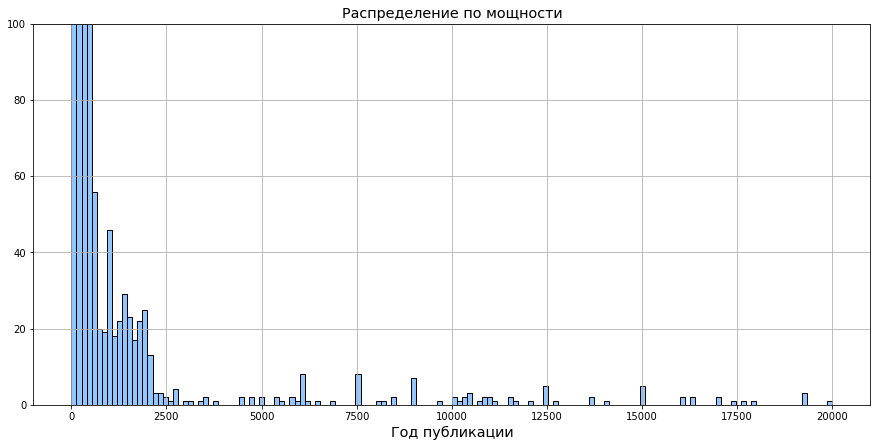

In [18]:
plt.figure(figsize=(15,7))
plt.ylim(0,100)
df['Power'].hist(bins=150, edgecolor='k')
plt.title('Распределение по мощности', fontsize='x-large')
plt.xlabel('Год публикации', fontsize='x-large')
plt.show()

In [19]:
print('Минимальная мощность:',df['Power'].min())
print('Максимальная максимальная мощность:',df['Power'].max())

Минимальная мощность: 0
Максимальная максимальная мощность: 20000


In [20]:
df.query('Power >= 400')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
1816,3200,small,2004,manual,1398,corolla,5000,6,petrol,toyota,no
2102,0,sedan,1999,unknown,1799,vectra,150000,1,petrol,opel,yes
2781,19500,suv,2004,auto,450,cayenne,125000,12,petrol,porsche,no
3289,16899,wagon,2003,auto,476,e_klasse,150000,9,petrol,mercedes_benz,no
3746,0,unknown,2017,manual,750,unknown,150000,8,petrol,smart,no
...,...,...,...,...,...,...,...,...,...,...,...
353489,12500,unknown,2017,manual,2000,other,60000,3,gasoline,chrysler,no
353629,2400,sedan,2007,manual,650,c2,150000,8,petrol,citroen,unknown
354041,20000,coupe,2006,auto,476,other,125000,7,petrol,mercedes_benz,no
354256,399,other,1994,unknown,1103,3er,150000,3,unknown,bmw,unknown


В двух столбцах замечены выбросы, которые могут повлиять на модель приобучении.

Соотвественно, удалим лишние строки с выбросами в годах. Их всего 171.

И также очистим строки с мощностью машин более 600 л.с

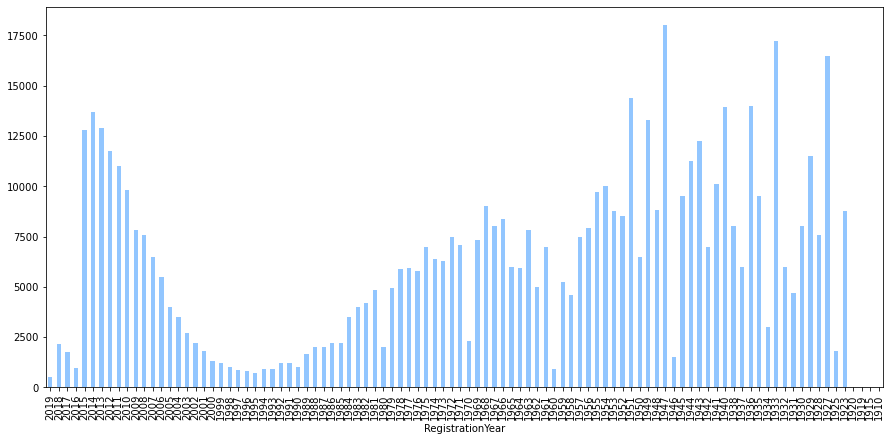

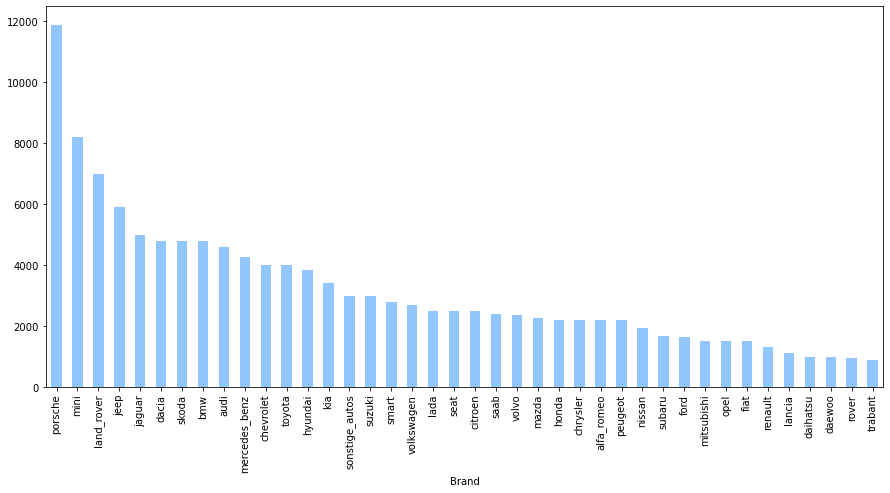

In [21]:
plt.figure(figsize=(15,7))
df.query('RegistrationYear >= 1885 and RegistrationYear <= 2022')\
    .groupby(['RegistrationYear']).median()\
    .sort_values(by='RegistrationYear', ascending=False)['Price']\
    .plot.bar()
plt.show()

plt.figure(figsize=(15,7))
df.groupby('Brand').median()['Price'].sort_values(ascending=False).plot.bar()
plt.show()

Избавимся от выбросов, а также возьмём наиболее актуальные годы для наших моделей

In [22]:
df = df.drop(df.query('Power >= 1000 or Power <= 20').index).reset_index(drop=True)
df = df.drop(df.query('RegistrationYear < 1920 or RegistrationYear > 2016').index).reset_index(drop=True)
df = df.drop(df.query('Price < 200').index).reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292376 entries, 0 to 292375
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              292376 non-null  int64 
 1   VehicleType        292376 non-null  object
 2   RegistrationYear   292376 non-null  int64 
 3   Gearbox            292376 non-null  object
 4   Power              292376 non-null  int64 
 5   Model              292376 non-null  object
 6   Kilometer          292376 non-null  int64 
 7   RegistrationMonth  292376 non-null  int64 
 8   FuelType           292376 non-null  object
 9   Brand              292376 non-null  object
 10  Repaired           292376 non-null  object
dtypes: int64(5), object(6)
memory usage: 24.5+ MB


In [23]:
#КОД РЕВЬЮЕРА

df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,292376.000000,292376.000000,292376.000000,292376.000000,292376.000000
mean,4917.547408,2002.885829,121.356934,128282.160642,6.187426
std,4610.917612,6.481977,54.520479,36668.163180,3.343622
min,200.000000,1927.000000,21.000000,5000.000000,1.000000
25%,1400.000000,1999.000000,80.000000,125000.000000,3.000000
50%,3250.000000,2003.000000,113.000000,150000.000000,6.000000
75%,7000.000000,2007.000000,150.000000,150000.000000,9.000000
max,20000.000000,2016.000000,999.000000,150000.000000,12.000000


Проверим корреляцию между признаками

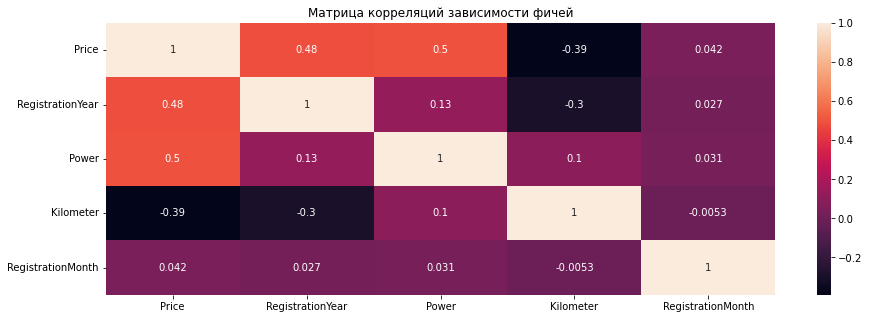

In [24]:
plt.figure(figsize=(15, 5))
plt.title('Матрица корреляций зависимости фичей')

sns.heatmap(df.corr(), annot = True)

plt.show()

Заметим, что сильно коррелирующих параметров нет, прослеживается только умеренная зависимость.

Прежде, чем обучать модель, подготовим данные для обработки:

* Применим OHE только для признаков, где мало разных признаков. То есть не будем брать признак Model
* Разделим выборку на тренировочную и тестовую
* Заменим 0 в целевом признаке на тренировочной выборке
* обучим на тренировочной выборке TargetEncoder на признаке Model и применим, повторим на тестовой
* применим стандартизацию
* добавим в тренировочную и тестовую выборку столбцы из OHE, чтобы сходилось количество признаков

Применим OHE на категориальные данные

In [25]:

df_ohe = pd.get_dummies(df, columns=cat_cols, drop_first=True)

df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292376 entries, 0 to 292375
Columns: 312 entries, Price to Repaired_yes
dtypes: int64(5), uint8(307)
memory usage: 96.8 MB


Разобьём данные на выборки

In [26]:
train, test = train_test_split(df,
                               test_size=0.20,
                               random_state=12345)

print('Размер тренировочной выборки:', train.shape,
      '\nРазмер тестовой выборки:', test.shape)

Размер тренировочной выборки: (233900, 11) 
Размер тестовой выборки: (58476, 11)


Заменим нули на трейне на пустые значения для заполнения:

In [27]:
train['Price'] = train['Price'].replace(0, np.nan)

train['Price'].isnull().sum()

0

Заполним теперь данные пропуски

In [28]:
train['Price'] = train['Price'].fillna(train.groupby(['RegistrationYear', 'Brand'])['Price'].transform('median'))

train[train['Price'].isna()]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired


Заполним оставшиеся строки медианой по году регистрации

In [29]:
train['Price'] = train['Price'].fillna(train.groupby(['RegistrationYear'])['Price'].transform('median'))

train[train['Price'].isna()]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired


In [30]:
train = pd.concat([train, df_ohe.drop(train.columns.drop(cat_cols), axis=1)], 
                  join='inner', 
                  axis=1)
test = pd.concat([test, df_ohe.drop(test.columns.drop(cat_cols), axis=1)], 
                 join='inner', 
                 axis=1)

train = train.drop(cat_cols, axis=1)
test = test.drop(cat_cols, axis=1)

print('Размер тренировочной выборки:', train.shape,
      '\nРазмер тестовой выборки:', test.shape)

Размер тренировочной выборки: (233900, 312) 
Размер тестовой выборки: (58476, 312)


Применим стандартизацию

In [31]:
train_features = train.drop('Price', axis=1)
train_target = train['Price']

test_features = test.drop('Price', axis=1)
test_target = test['Price']

num_cols = ['Kilometer', 'Power', 'RegistrationYear', 'RegistrationMonth']
scaler = StandardScaler()
scaler.fit(train_features[num_cols]) 

train_features[num_cols] = scaler.transform(train_features[num_cols])
test_features[num_cols] = scaler.transform(test_features[num_cols])

## Обучение моделей

Обучите разные модели. Для каждой попробуйте различные гиперпараметры.

Воспользуемся несколькими библиотеками и моделями машинного обучения:

* Линейная регрессия
* Дерево решений
* Случайный лес
* Градиентный бустинг
---
Такими библиотеками, как:

* sklearn
* XGBoost
* LightGBM
* CatBoost

Делим датасет на выборки

### Линейная регрессия

In [32]:
lnr = LinearRegression()

lnr.fit(train_features, train_target)


scores = cross_validate(lnr, train_features,train_target, cv = 3,
                        scoring = ('neg_mean_squared_error'),
                        return_train_score = True)


print('Время обучения модели: %.2f секунд' %scores['fit_time'].mean(),
      '\nRMSE на кросс-валидации:', (-scores['train_score'].mean())**0.5)

Время обучения модели: 2.34 секунд 
RMSE на кросс-валидации: 2580.860946705983


* После обработки данных метрика на валидационной выборке составила 2580
* время обучения модели 2.41 секунды

Для сравнения обучим ещё модели

Для подбора параметров моделей будем использовать `RandomizedSearchSV`, чтобы ускорить вычисления.

Создадим функцию, которая обучит и вернет модель и метрику:

In [33]:
analisys = pd.DataFrame({'model':[], 'RMSE':[], 'time_to_predict':[], 'time_to_fit':[]})
all_models = []

def train_model(model, parameters=None):
    
    model_random = RandomizedSearchCV(estimator=model,
                                      param_distributions=parameters, # используем параметры
                                      n_iter=100, 
                                      scoring='neg_root_mean_squared_error', # используем необходимую метрику
                                      cv=3, 
                                      verbose=1)
    
    # посмотрим время обучения 
    start = time()
    model_random.fit(train_features, train_target)
    time_to_fit = model_random.cv_results_['mean_fit_time'][0]
    print('Время обучения модели %.2f секунд' %time_to_fit)
    
    time_to_predict = model_random.cv_results_['mean_score_time'][0]
    print('Модель предсказывает за %.2f секунд' %time_to_predict)
    
    # высчитаем метрики
    rmse = -model_random.best_score_
    
    print('Лучшие параметры:', model_random.best_params_)
    print('RMSE обученной модели:', rmse)
    
    # заполним все таблицы    
    all_models.append(model_random)
    row = []
    row.extend([model, rmse, time_to_predict, time_to_fit])
    analisys.loc[len(analisys.index)] = row
    
    return model_random.best_estimator_, rmse

### Дерево решений

In [35]:
# зададим рандомные параметры

ran_grid_tree = {"max_depth": list(range(15, 26))}

dtr = DecisionTreeRegressor(random_state = 12345)

dtr_random, rmse_dtr = train_model(dtr, ran_grid_tree) # обучим и сохраним значения

C:\Users\Naix3\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 11 is smaller than n_iter=100. Running 11 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 11 candidates, totalling 33 fits
Время обучения модели 3.36 секунд
Модель предсказывает за 0.11 секунд
Лучшие параметры: {'max_depth': 15}
RMSE обученной модели: 1877.5383646795015


### LightGBM

In [36]:
rand_lgbm_param = {
    'max_depth': [5, 10, 15, 25, 35],
    'learning_rate': [0.01, 0.1, 0.15]
}

gbm = lgb.LGBMRegressor(boosting_type='gbdt',
                         objective = 'regression',
                         metric = 'RMSE', 
                        random_state = 12345)

gbm_random, rmse_gbm = train_model(gbm, rand_lgbm_param)

C:\Users\Naix3\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 15 is smaller than n_iter=100. Running 15 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 15 candidates, totalling 45 fits
Время обучения модели 0.99 секунд
Модель предсказывает за 0.16 секунд
Лучшие параметры: {'max_depth': 15, 'learning_rate': 0.15}
RMSE обученной модели: 1632.175544522768


### XGboost

In [37]:
rand_xgb_param = {
    'max_depth': [12, 13, 14, 15],
    'learning_rate': [0.1, 0.15, 0.3]
}

xb = xgb.XGBRegressor(booster='gbtree', 
                      eval_metric='rmse', 
                      use_rmm=True, 
                      random_state = 12345)

xb_random, rmse_xb = train_model(xb, rand_xgb_param)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


C:\Users\Naix3\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 12 is smaller than n_iter=100. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Время обучения модели 41.04 секунд
Модель предсказывает за 0.27 секунд
Лучшие параметры: {'max_depth': 14, 'learning_rate': 0.15}
RMSE обученной модели: 1530.8628144782895


### Catboost

In [38]:
rand_cat_param = {
    'max_depth': [8, 9, 10, 11],
    'learning_rate': [0.01, 0.1, 0.2]
}

cat = CatBoostRegressor(verbose=False, 
                        task_type='GPU',
                       random_state = 12345)

cat_random, rmse_cat = train_model(cat, rand_cat_param)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


C:\Users\Naix3\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 12 is smaller than n_iter=100. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Время обучения модели 6.86 секунд
Модель предсказывает за 0.04 секунд
Лучшие параметры: {'max_depth': 11, 'learning_rate': 0.2}
RMSE обученной модели: 1505.6626755803893


### Выводы

Построим диаграммы с полученными метриками у разных моделей

,model,RMSE,time_to_predict,time_to_fit,names
0,DecisionTreeRegressor(random_state=12345),1877.538365,0.108197,3.355742,DecisionTree
1,"LGBMRegressor(metric='RMSE', objective='regres...",1632.175545,0.164198,0.987665,LightGBM
2,"XGBRegressor(base_score=None, booster='gbtree'...",1530.862814,0.274027,41.039090,XGBoost
3,<catboost.core.CatBoostRegressor object at 0x0...,1505.662676,0.040760,6.864216,CatBoost


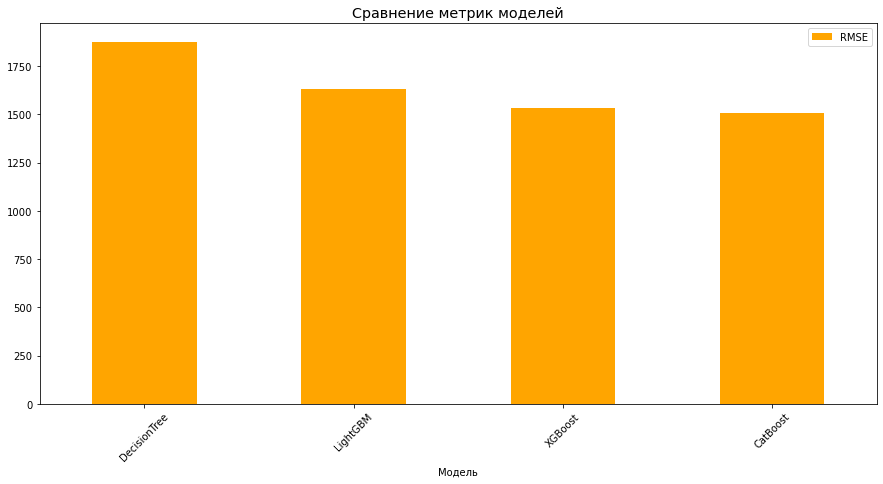

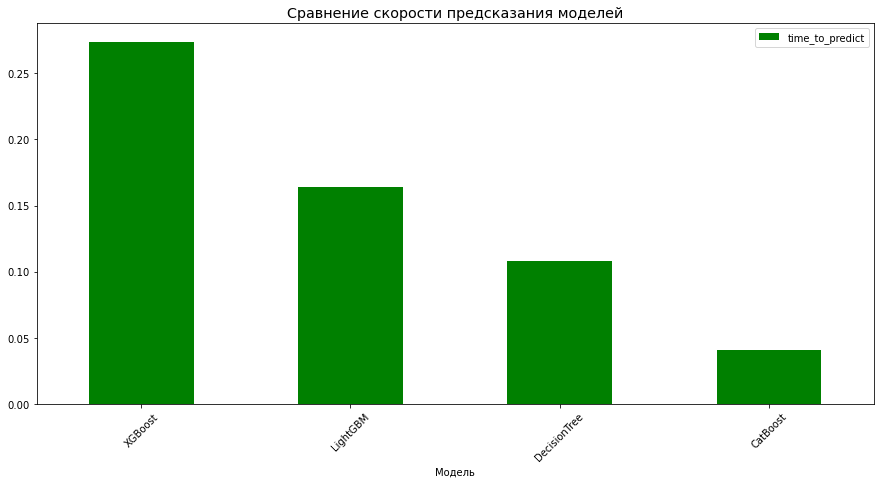

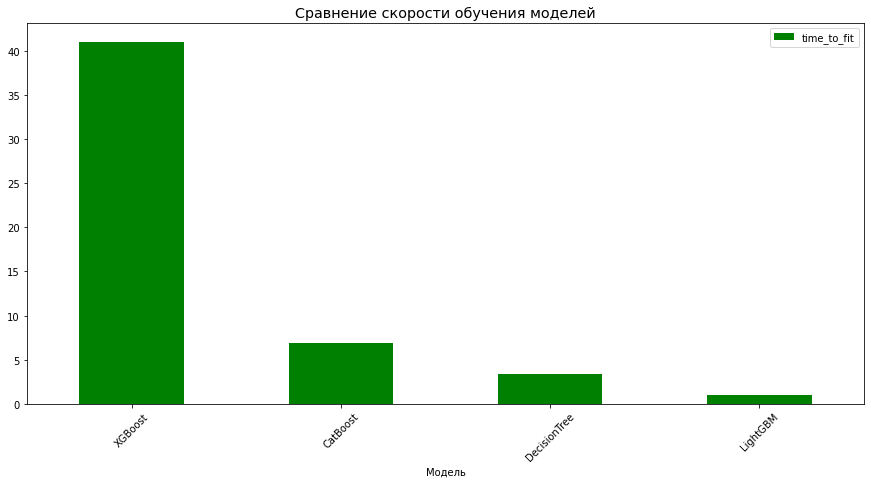

In [75]:
all_names = pd.DataFrame({'names':['DecisionTree', 'LightGBM', 'XGBoost', 'CatBoost']})
analisys = pd.concat([analisys, all_names], axis=1, join='inner')
display(analisys)

analisys.plot.bar(y='RMSE', x='names', rot=45, figsize=(15,7), color='orange')
plt.title('Сравнение метрик моделей', fontsize='x-large')
plt.xlabel('Модель')
plt.show()

analisys.sort_values(by='time_to_predict', ascending=False)\
.plot.bar(y='time_to_predict', x='names', rot=45, figsize=(15,7), color='green')
plt.title('Сравнение скорости предсказания моделей', fontsize='x-large')
plt.xlabel('Модель')
plt.show()

analisys.sort_values(by='time_to_fit', ascending=False)\
.plot.bar(y='time_to_fit', x='names', rot=45, figsize=(15,7), color='green')
plt.title('Сравнение скорости обучения моделей', fontsize='x-large')
plt.xlabel('Модель')
plt.show()

Согласно полученным моделям делаем следующий вывод:
* Catboost явно превосходит абсолютно все модели в показателях скорости предсказания и метрике, но имеет средний показатель скорости обучения модели, тем не менее выбираем данную модель для тестирования

## Анализ моделей

Рассмотрим результаты обучения на тестовой выборке:

### Catboost

In [40]:
start = time()
predicted = cat_random.predict(test_features)
print('Модель предсказывает не тестовой выборке за %.2f секунд' %(time() - start))

rmse_on_test = mean_squared_error(test_target, predicted, squared=False)
print('Итоговый RMSE на тестовой выборке:', rmse_on_test)

Модель предсказывает не тестовой выборке за 0.11 секунд
Итоговый RMSE на тестовой выборке: 1514.0457901423276


## Вывод

В результате проделанной работы все обученные модели удовлетворяют требованию в показатель метрики RMSE < 2500, однако в итоге наилучшими параметрами метрики и скорости обучения является модель Catboost, имеющая параметры {'max_depth': 11, 'learning_rate': 0.2}